In [7]:
from langchain.llms import OpenAI # for new models
from langchain.chat_models import ChatOpenAI # for older models
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.schema import SystemMessage, HumanMessage
import os
import json
import pandas as pd
from tqdm import tqdm
import tiktoken
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Load OpenaAI API key
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Define Classification Function

In [8]:
def count_tokens(prompt):
    encoding = tiktoken.get_encoding("cl100k_base")
    return len(encoding.encode(prompt))

def classify_sentence(input_text, template, classes=["FUN", "STR", "MIX", "OTH"], model="gpt-3.5-turbo"):

    # Format the classes correctly for the prompt
    class_labels = ", ".join(classes)  
    
    # Define a prompt template for classification
    prompt_template = PromptTemplate(
        input_variables=["text", "class_labels"],
        template=template
    )

    # Create an OpenAI LLM instance
    llm = ChatOpenAI(
        model=model,
        temperature=0,
        max_retries=2,
        max_tokens=10  # Slightly increased for safety
    )

    # Set up the classification chain
    classification_chain = LLMChain(llm=llm, prompt=prompt_template)

    # Perform Classification
    pred_class = classification_chain.run(text=input_text, class_labels=class_labels).strip()

    # Calculate token count
    token_count = count_tokens(prompt_template.format(text=input_text, class_labels=class_labels))

    # Debugging statement (prints the formatted prompt)
    #print(f"Generated Prompt:\n{prompt_template.format(text=input_text, class_labels=class_labels)}")

    return pred_class, token_count


In [ ]:
# Sample Sentences
input_text = "Additionally, the stopper 108 is used at the distal end of the wire where the loop is formed to substantially secure the loop closed." # MIX
input_text = "Provisional Patent Application number 62/571,193; filed Oct. 11, 2017; and entitled INSECT VACUUM AND TRAP ATTACHMENT SYSTEMS." #OTH
input_text = "In some embodiments, the horizontal position of the idler support block 1213 may be adjustable to maintain tension on the chain 1212." #FUN
input_text = "If there are no allocated cells to a hub using the previous criterion, the first allocated cell will be the closest cell to that hub." #FUN
input_text = "The rigid foam layer 50 is typically selected from the group of polyurethane foams, polyurea foams, and combinations thereof." # STR

# Define Initial Prompt Template for testing
template = """
        Your task is to classify a given sentence as either: 
        * 'FUN' - if the sentence describes only the functioning or behavior of a device;
        * 'STR' - if the sentence describes only the structure or architecture of a device;
        * 'MIX' - if the sentence describes both the functioning and the structure of a device;
        * 'OTH' - if the sentence cannot be classified according to any of the previous classes.
        
        The output should only contain one of the class labels: {class_labels}.
        
        Sentence: "{text}"
        Class:
"""

# Test the Classification Function
pred_class, token_count = classify_sentence(input_text=input_text, template=template)
print(f"Token Count: {token_count}")
print(f"Predicted Category: {pred_class}")

Token Count: 152
Predicted Category: STR


# Define Prompts

In [15]:
# Define Prompt Components
context = "Patent documents describe the functioning and the structure of patented systems."

def_FUN = "the functions, processes, actions or tasks that the system or its components are capable of performing to achieve their intended purpose."
def_STR = "the architecture, arrangements, attributes, parameters, properties and features of the system and its components."

def_FUNCTIONING = "The functioning of a system refers to " + def_FUN
def_STRUCTURE = "The structure of a system refers to " + def_STR

def_not_FUNCTIONING = "The functioning of a system do not refer to " + def_STR
def_not_STRUCTURE = "The structure of a system do not refer to " + def_FUN

task = """Your task is to classify a given sentence as either: 
* 'FUN' - if the sentence describes only the functioning or behavior of a device;
* 'STR' - if the sentence describes only the structure or architecture of a device;
* 'MIX' - if the sentence describes both the functioning and the structure of a device;
* 'OTH' - if the sentence cannot be classified according to any of the previous classes.
The output should only contain one of the class labels: {class_labels}."""

example_FUN = "Sentence: '{text}' \nClass:"
example_STR = "Sentence: '{text}' \nClass:"
example_MIX = "Sentence: '{text}' \nClass:"
example_OTH = "Sentence: '{text}' \nClass:"

output_format ="Sentence: '{text}' \nClass:"

In [16]:
# Define Prompt 1: task
prompt_1 = []
prompt_1.append(task)
prompt_1.append(output_format)
template_1 = "\n".join(prompt_1)
print(f"\n\nPrompt 1:\n{template_1}")

'''----------------------------------------------------------------------------------'''

# Define Prompt 2 : context + task
prompt_2 = []
prompt_2.append(context)
prompt_2.append(task)
prompt_2.append(output_format)
template_2 = "\n".join(prompt_2)
print(f"\n\nPrompt 2:\n{template_2}")

# Define Prompt 3 : definitions + task
prompt_3 = []
prompt_3.append(def_FUNCTIONING)
prompt_3.append(def_STRUCTURE)
prompt_3.append(task)
prompt_3.append(output_format)
template_3 = "\n".join(prompt_3)
print(f"\n\nPrompt 3:\n{template_3}")

'''----------------------------------------------------------------------------------'''

# Define Prompt 4 : context + definitions + task
prompt_4 = []
prompt_4.append(context)
prompt_4.append(def_FUNCTIONING)
prompt_4.append(def_STRUCTURE)
prompt_4.append(task)
prompt_4.append(output_format)
template_4 = "\n".join(prompt_4)
print(f"\n\nPrompt 4:\n{template_4}")



Prompt 1:
Your task is to classify a given sentence as either: 
* 'FUN' - if the sentence describes only the functioning or behavior of a device;
* 'STR' - if the sentence describes only the structure or architecture of a device;
* 'MIX' - if the sentence describes both the functioning and the structure of a device;
* 'OTH' - if the sentence cannot be classified according to any of the previous classes.
The output should only contain one of the class labels: {class_labels}.
Sentence: '{text}' 
Class:


Prompt 2:
Patent documents describe the functioning and the structure of patented systems.
Your task is to classify a given sentence as either: 
* 'FUN' - if the sentence describes only the functioning or behavior of a device;
* 'STR' - if the sentence describes only the structure or architecture of a device;
* 'MIX' - if the sentence describes both the functioning and the structure of a device;
* 'OTH' - if the sentence cannot be classified according to any of the previous classes.
Th

#  Classify Sentences

In [17]:
# Import data
test_df = pd.read_excel("/home/fantoni/patent-sentence-classification/data/test.xlsx")
test_df

,sent_id,sent,sent_tag,sent_class
0,2534415,"However, the described techniques may be imple...",FUN,0
1,1930270,The louvers 138 are operable to pivot upward a...,FUN,0
2,2600702,"In the depictions in figures 2 and 9-12, the p...",STR,1
3,1847580,The sensor component 814 may further include a...,STR,1
4,2106934,Choosing two or more remote devices 114 can tr...,FUN,0
...,...,...,...,...
596,568362,"g, ROC plots for H3K4me3 peaks identified from...",OTH,3
597,445435,The average skin temperatures found with the C...,STR,1
598,364327,Examples of the other halogen atoms represente...,STR,1
599,1847736,The rotor rotates when the AC voltage at a pre...,FUN,0


In [ ]:
model =  "gpt-3.5-turbo"
template_name = "template_1" # set also in classify function

# Initialize results dictionary
results = {
    'sent_id': [],
    'sent': [],
    'true_class': [],
    'pred_class': [],
    'errors': [],
    'prompt_tokens': []
}

# Perform Classification
for i, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Processing Sentences"):    
    sent_id = row['sent_id']
    sent = row['sent']
    true_class = row['sent_tag']
    
    try:
        results['sent_id'].append(sent_id)
        results['sent'].append(sent)
        results['true_class'].append(true_class)

        # Get classification
        pred_class, token_count = classify_sentence(input_text=sent, model=model, template=None)

        # Validate classification
        if pred_class not in ["FUN", "STR", "MIX", "OTH"]:
            pred_class = "UNK"  # Default to UNK if invalid classification

        results['pred_class'].append(pred_class)
        results['errors'].append(None)  # No error occurred
        results['prompt_tokens'].append(token_count)  # Append token count when successful

    except Exception as e:
        # Handle any errors that occur during processing
        results['pred_class'].append("ERROR")
        results['prompt_tokens'].append("ERROR") 
        results['errors'].append(str(e))

# Convert results to DataFrame and Save
result_df = pd.DataFrame(results)
result_df.to_excel(f'/home/fantoni/patent-sentence-classification/results/prompting/{model}_{template_name}.xlsx', index = False)

# Analyse Results

{
    "precision": 0.6826,
    "recall": 0.3444,
    "f1": 0.3761
}


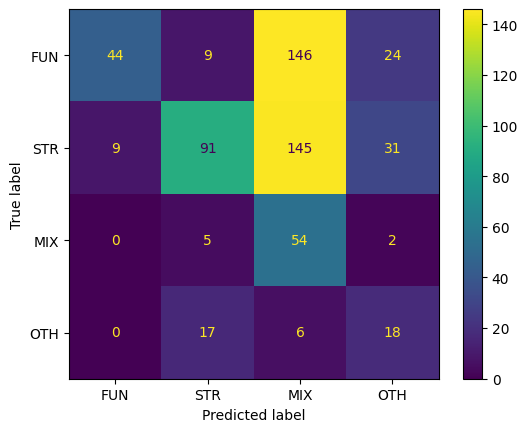

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import ast

# Import data
file_path = "/home/fantoni/patent-sentence-classification/results/prompting/gpt-3.5-turbo_template_1.xlsx"
file_name = os.path.splitext(os.path.basename(file_path))[0]
result_df = pd.read_excel(file_path)

# Set labels
labels = ['FUN', 'STR', 'MIX', 'OTH']
true_labels = result_df['true_class']  
predicted_labels = result_df['pred_class']

# Calculate classification metrics
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
results = {
    'precision': round(precision, 4),  # Rounded for better readability
    'recall': round(recall, 4),
    'f1': round(f1, 4)
}
print(json.dumps(results, indent=4))  # Pretty-print the JSON

# Save Metrics as JSON
output_file_path = f"/home/fantoni/patent-sentence-classification/results/prompting/{file_name}.json"
with open(output_file_path, "w") as f:
    json.dump(results, f, indent=4)  # Save as formatted JSON

# Save Classification Report
class_report = classification_report(true_labels, predicted_labels, labels=labels, target_names=labels, zero_division=0)
output_file_path = f"/home/fantoni/patent-sentence-classification/results/prompting/{file_name}_cls_rep.txt"
with open(output_file_path, "w") as f:
    f.write("Classification Report:\n")
    f.write(class_report)

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

# Cost of Prompting

To calculate cost: https://openai.com/api/pricing/

In [25]:
# Worst case Scenario
input_tokens = 200 
output_tokens = 3
n_sentence = 600

# gpt-4o
cost_prompt = input_tokens * 2.50/1000000
cost_output = output_tokens * 10/1000000

# gpt-3.5-turbo
cost_prompt = input_tokens * 3/1000000
cost_output = output_tokens * 6/1000000

# gpt-3.5-turbo-0125
cost_prompt = input_tokens * 0.5/1000000
cost_output = output_tokens * 1.5/1000000

print(f"Cost Prompt: {cost_prompt:.5f}$")
print(f"Cost Output: {cost_output:.5f}$")
print(f"Tot. Cost per Sentence: {cost_prompt + cost_output:.5f}$")
print(f"Tot. Cost for {n_sentence} Sentence: {(cost_prompt + cost_output)*n_sentence:.2f}$")

Cost Prompt: 0.00010$
Cost Output: 0.00000$
Tot. Cost per Sentence: 0.00010$
Tot. Cost for 600 Sentence: 0.06$
